In [30]:
# conventional libraries
import os
import calendar
import pandas as pd
import numpy as np

# data visualizations
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
import seaborn as sns
import matplotlib.pyplot as plt

# algorithm
from scipy.sparse import coo_matrix
from implicit.als import AlternatingLeastSquares
from implicit.evaluation import ranking_metrics_at_k
from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

# RFM Analysis 

Used to segregate the customers based on behaviors

RFM helps in segregating:

the more recent the purchase, the more responsive the customer is to promotions
the more frequently the customer buys, the more engaged and satisfied they are
monetary value differentiates heavy spenders from low-value purchasers


In [31]:
df = pd.read_csv("df_cleaned.csv")
df = df.drop(df[df.CustomerID == 1].index)

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning:

Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.



In [32]:
df_cus = df.loc[:,['InvoiceNo','CustomerID']]
df_dp = df_cus.drop_duplicates()


In [33]:
frequency = df_dp.groupby(['CustomerID']).count()
frequency = frequency.reset_index()
df_fre = frequency.rename(columns = {'InvoiceNo':'Frequency'})
df_fre.head()

,CustomerID,Frequency
0,12347,7
1,12348,4
2,12349,1
3,12350,1
4,12352,7


In [34]:
df_time = df.loc[:,['CustomerID','InvoiceDate']]
df_time = df_time.drop_duplicates()
df_time.InvoiceDate = pd.to_datetime(df_time.InvoiceDate)


In [35]:
from datetime import datetime
from datetime import date
from datetime import time

In [36]:
df_time = df_time.sort_values('InvoiceDate',ascending=False)
df_time = df_time.drop_duplicates(subset = 'CustomerID')
df_time['Timenow'] = datetime(2012,1,19,23,10)

In [37]:
df_time['Recency'] = df_time.Timenow - df_time.InvoiceDate
df_time = df_time.sort_values('CustomerID')
df_time

,CustomerID,InvoiceDate,Timenow,Recency
517778,12347,2011-12-07 15:52:00,2012-01-19 23:10:00,43 days 07:18:00
347698,12348,2011-09-25 13:13:00,2012-01-19 23:10:00,116 days 09:57:00
469821,12349,2011-11-21 09:51:00,2012-01-19 23:10:00,59 days 13:19:00
77623,12350,2011-02-02 16:01:00,2012-01-19 23:10:00,351 days 07:09:00
423109,12352,2011-11-03 14:37:00,2012-01-19 23:10:00,77 days 08:33:00
...,...,...,...,...
107407,18280,2011-03-07 09:52:00,2012-01-19 23:10:00,318 days 13:18:00
215592,18281,2011-06-12 10:53:00,2012-01-19 23:10:00,221 days 12:17:00
503039,18282,2011-12-02 11:43:00,2012-01-19 23:10:00,48 days 11:27:00
513395,18283,2011-12-06 12:02:00,2012-01-19 23:10:00,44 days 11:08:00


In [38]:
num = []
for i in df_time.Recency :
    num.append(i.days)
    
df_time['Recency'] = num
df_time

,CustomerID,InvoiceDate,Timenow,Recency
517778,12347,2011-12-07 15:52:00,2012-01-19 23:10:00,43
347698,12348,2011-09-25 13:13:00,2012-01-19 23:10:00,116
469821,12349,2011-11-21 09:51:00,2012-01-19 23:10:00,59
77623,12350,2011-02-02 16:01:00,2012-01-19 23:10:00,351
423109,12352,2011-11-03 14:37:00,2012-01-19 23:10:00,77
...,...,...,...,...
107407,18280,2011-03-07 09:52:00,2012-01-19 23:10:00,318
215592,18281,2011-06-12 10:53:00,2012-01-19 23:10:00,221
503039,18282,2011-12-02 11:43:00,2012-01-19 23:10:00,48
513395,18283,2011-12-06 12:02:00,2012-01-19 23:10:00,44


In [39]:
df_mty = df.loc[:,['CustomerID','InvoiceNo','UnitPrice','Quantity']]
df_mty['Monetary'] = df_mty['UnitPrice'] * df_mty['Quantity']
monetary = df_mty.groupby('CustomerID')[['Monetary']].sum()
monetary = monetary.reset_index()
monetary

,CustomerID,Monetary
0,12347,4310.00
1,12348,1797.24
2,12349,1757.55
3,12350,334.40
4,12352,1665.74
...,...,...
4328,18280,180.60
4329,18281,80.82
4330,18282,178.05
4331,18283,2039.58


In [40]:
df_final = df_fre.merge(monetary)
df_final['BasketSize'] = (df_final['Monetary']/df_final['Frequency']).round(2)
df_final

,CustomerID,Frequency,Monetary,BasketSize
0,12347,7,4310.00,615.71
1,12348,4,1797.24,449.31
2,12349,1,1757.55,1757.55
3,12350,1,334.40,334.40
4,12352,7,1665.74,237.96
...,...,...,...,...
4328,18280,1,180.60,180.60
4329,18281,1,80.82,80.82
4330,18282,2,178.05,89.02
4331,18283,16,2039.58,127.47


In [41]:
df_recency = df_time.loc[:,['CustomerID','Recency']]
df_final = df_final.merge(df_recency)
df_final

,CustomerID,Frequency,Monetary,BasketSize,Recency
0,12347,7,4310.00,615.71,43
1,12348,4,1797.24,449.31,116
2,12349,1,1757.55,1757.55,59
3,12350,1,334.40,334.40,351
4,12352,7,1665.74,237.96,77
...,...,...,...,...,...
4328,18280,1,180.60,180.60,318
4329,18281,1,80.82,80.82,221
4330,18282,2,178.05,89.02,48
4331,18283,16,2039.58,127.47,44


In [42]:
#Frequency bulma
def FScore(x,p,d):
    if x <= d[p][0.20]:
        return 0
    elif x <= d[p][0.40]:
        return 1
    elif x <= d[p][0.60]: 
        return 2
    elif x <= d[p][0.80]:
        return 3
    else:
        return 4

quantiles = df_final.quantile(q=[0.20,0.40,0.60,0.80])
quantiles = quantiles.to_dict()
df_final['Freq_Tile'] = df_final['Frequency'].apply(FScore, args=('Frequency',quantiles,))

#Recency 
df_final = df_final.sort_values('Recency',ascending=True)
df_final['Rec_Tile'] = pd.qcut(df_final['Recency'],5,labels=False)

#Monetary 
df_final['Mone_Tile'] = pd.qcut(df_final['Monetary'],5,labels=False)

# instead of zero, plus 1 
df_final['Rec_Tile'] = df_final['Rec_Tile'] + 1
df_final['Freq_Tile'] = df_final['Freq_Tile'] + 1
df_final['Mone_Tile'] = df_final['Mone_Tile'] + 1

# Add to dataframe
df_final['RFM Score'] = df_final['Rec_Tile'].map(str) + df_final['Freq_Tile'].map(str) + df_final['Mone_Tile'].map(str)
df_final.head()

,CustomerID,Frequency,Monetary,BasketSize,Recency,Freq_Tile,Rec_Tile,Mone_Tile,RFM Score
2175,15311,91,60632.75,666.29,41,5,1,5,155
3749,17490,7,2092.32,298.90,41,5,1,5,155
3708,17428,28,17256.85,616.32,41,5,1,5,155
1256,14051,23,15610.39,678.71,41,5,1,5,155
3679,17389,34,31833.68,936.28,41,5,1,5,155


Summing the RFM Score
One of the most straightforward methods is to sum our scores to a single number and define RFM levels for each score range.

In [43]:
# Calculate RFM_Score
df_final['RFM_Sum'] = df_final[['Freq_Tile','Rec_Tile','Mone_Tile']].sum(axis=1)
df_final.head()

,CustomerID,Frequency,Monetary,BasketSize,Recency,Freq_Tile,Rec_Tile,Mone_Tile,RFM Score,RFM_Sum
2175,15311,91,60632.75,666.29,41,5,1,5,155,11
3749,17490,7,2092.32,298.90,41,5,1,5,155,11
3708,17428,28,17256.85,616.32,41,5,1,5,155,11
1256,14051,23,15610.39,678.71,41,5,1,5,155,11
3679,17389,34,31833.68,936.28,41,5,1,5,155,11


Making Segmentation For Customers Depends On RFM Sum Score
We can get creative and hypothesize about what each score range entails, but for this exercise I will take inspiration from some common segment names.


In [44]:
# Define rfm_level function
def rfm_level(df):
    if df['RFM_Sum'] >= 9:
        return 'Can\'t Loose Them'
    elif ((df['RFM_Sum'] >= 8) and (df['RFM_Sum'] < 9)):
        return 'Champions'
    elif ((df['RFM_Sum'] >= 7) and (df['RFM_Sum'] < 8)):
        return 'Loyal'
    elif ((df['RFM_Sum'] >= 6) and (df['RFM_Sum'] < 7)):
        return 'Potential'
    elif ((df['RFM_Sum'] >= 5) and (df['RFM_Sum'] < 6)):
        return 'Promising'
    elif ((df['RFM_Sum'] >= 4) and (df['RFM_Sum'] < 5)):
        return 'Needs Attention'
    else:
        return 'Require Activation'
# Create a new variable RFM_Level
df_final['RFM_Level'] = df_final.apply(rfm_level, axis=1)
# Print the header with top 5 rows to the console
df_final = df_final.set_index('CustomerID')
df_final.head()

,Frequency,Monetary,BasketSize,Recency,Freq_Tile,Rec_Tile,Mone_Tile,RFM Score,RFM_Sum,RFM_Level
CustomerID,,,,,,,,,,
15311,91,60632.75,666.29,41,5,1,5,155,11,Can't Loose Them
17490,7,2092.32,298.90,41,5,1,5,155,11,Can't Loose Them
17428,28,17256.85,616.32,41,5,1,5,155,11,Can't Loose Them
14051,23,15610.39,678.71,41,5,1,5,155,11,Can't Loose Them
17389,34,31833.68,936.28,41,5,1,5,155,11,Can't Loose Them


Treating Outliers

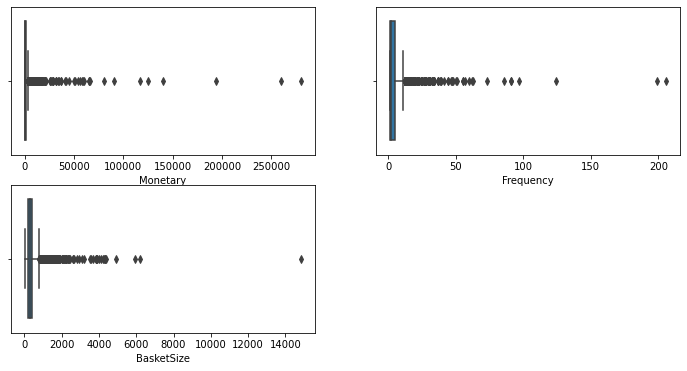

In [45]:
num_features = df_final[['Monetary','Frequency', 'BasketSize']]
r = c = 0
fig,ax = plt.subplots(2,2,figsize=(12,6))

for n,i in enumerate(num_features):
    sns.boxplot(x=i, data=df_final,ax=ax[r,c])
    c+=1
    if (n+1)%2==0:
        r+=1
        c=0
ax[r,c].axis("off")
plt.show()

Based on the above box plots, it's visible that Monetary and Frequency attributes have outliers. Since clustering algorithms like K-means are susceptible to outliers we will be treating them by capping them at 95% quantile.

In [46]:
# remove outliers for Quantity
df_final = df_final[df_final['Monetary'] < 10000]
df_final = df_final[df_final['BasketSize'] < 3000]
df_final = df_final[df_final['Frequency'] < 40]

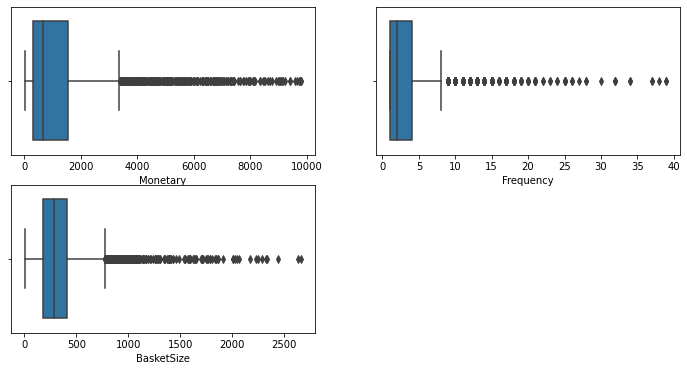

In [47]:
num_features = df_final[['Monetary','Frequency', 'BasketSize']]
r = c = 0
fig,ax = plt.subplots(2,2,figsize=(12,6))

for n,i in enumerate(num_features):
    sns.boxplot(x=i, data=df_final,ax=ax[r,c])
    c+=1
    if (n+1)%2==0:
        r+=1
        c=0
ax[r,c].axis("off")
plt.show()

In [48]:
# Calculate average values for each RFM_Level, and return a size of each segment 
rfm_level_agg = df_final.groupby('RFM_Level').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']}).round(1)
# Print the aggregated dataset
print(rfm_level_agg)

                   Recency Frequency Monetary      
                      mean      mean     mean count
RFM_Level                                          
Can't Loose Them     116.0       5.8   2088.9  2088
Champions            182.8       1.9    581.6   609
Loyal                204.8       1.4    335.8   706
Needs Attention       58.9       1.1    190.1   128
Potential            108.9       1.4    321.2   395
Promising             75.3       1.3    247.0   257
Require Activation    48.5       1.0    159.8    40


In [63]:
rfm = df_final.reset_index()

,CustomerID,Frequency,Monetary,BasketSize,Recency,Freq_Tile,Rec_Tile,Mone_Tile,RFM Score,RFM_Sum,RFM_Level
0,17490,7,2092.32,298.90,41,5,1,5,155,11,Can't Loose Them
1,17364,11,4462.68,405.70,41,5,1,5,155,11,Can't Loose Them
2,12526,3,1316.66,438.89,41,3,1,4,134,8,Champions
3,14422,6,4263.64,710.61,41,4,1,5,145,10,Can't Loose Them
4,14441,4,1712.89,428.22,41,4,1,4,144,9,Can't Loose Them
...,...,...,...,...,...,...,...,...,...,...,...
4218,18011,1,102.79,102.79,414,1,5,1,511,7,Loyal
4219,14142,1,311.81,311.81,414,1,5,2,512,8,Champions
4220,17968,1,265.10,265.10,414,1,5,2,512,8,Champions
4221,15165,1,487.75,487.75,414,1,5,3,513,9,Can't Loose Them


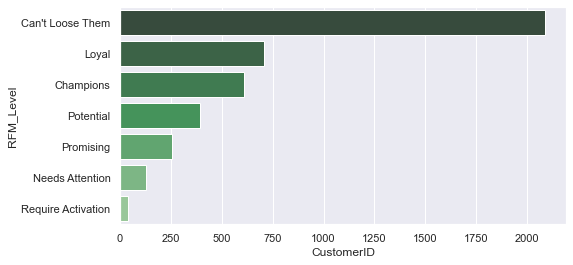

In [64]:
plo1 = rfm.groupby('RFM_Level')['CustomerID'].nunique().sort_values(ascending=False).reset_index()
sns.set(rc={'figure.figsize':(8, 4)})
sns.barplot(data=plo1, x = 'CustomerID', y = 'RFM_Level', palette = 'Greens_d', orient = 'h')

Normalisieren

In [49]:
clustering_fm = df_final[['Recency',"Frequency","Monetary"]].copy()
clustering_fm.head()

min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(clustering_fm)
data_scaled2 = pd.DataFrame(x_scaled)
data_scaled2.head()

,0,1,2
0,0.0,0.157895,0.213223
1,0.0,0.263158,0.455116
2,0.0,0.052632,0.134068
3,0.0,0.131579,0.434804
4,0.0,0.078947,0.174503


Hopkins Test
The Hopkins statistic, is a statistic which gives a value which indicates the cluster tendency, in other words: how well the data can be clustered.

If the value is between {0.01, ...,0.3}, the data is regularly spaced.

If the value is around 0.5, it is random.

If the value is between {0.7, ..., 0.99}, it has a high tendency to cluster.

In [50]:
#Calculating the Hopkins statistic
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [51]:
for i in range(5):
    print('Hopkins statistic value is:',round(hopkins(data_scaled2),3))

Hopkins statistic value is: 0.969
Hopkins statistic value is: 0.968
Hopkins statistic value is: 0.964
Hopkins statistic value is: 0.969
Hopkins statistic value is: 0.967


Since the Hopkins test value hovers around 0.95, therefore given data have high clustering tendency.

K-Means Segmentation

Text(0.5, 1.0, 'Elbow plot for optimal number of clusters')

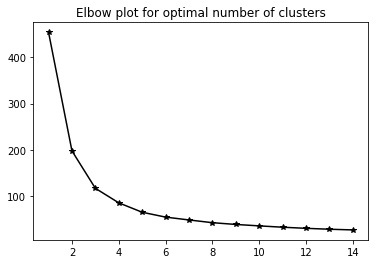

In [52]:
wscc = []
for i in range(1,15): 
    kmeans = KMeans(n_clusters=i, init="k-means++",random_state=0)
    kmeans.fit(data_scaled2)
    wscc.append(kmeans.inertia_)  

plt.plot(range(1,15),wscc,marker="*",c="black")
plt.title("Elbow plot for optimal number of clusters")

In [53]:
# silhouette analysis
from sklearn.metrics import silhouette_score
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(data_scaled2)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(data_scaled2, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, round(silhouette_avg,2)))

For n_clusters=2, the silhouette score is 0.57
For n_clusters=3, the silhouette score is 0.56
For n_clusters=4, the silhouette score is 0.5
For n_clusters=5, the silhouette score is 0.46
For n_clusters=6, the silhouette score is 0.41
For n_clusters=7, the silhouette score is 0.39
For n_clusters=8, the silhouette score is 0.38


Using silhouette analysis k=3 seems to be the optimal number of clusters.

In [54]:
# final model with k=3
kmeans = KMeans(n_clusters=3, max_iter=50,random_state=1)
kmeans.fit(data_scaled2)

KMeans(max_iter=50, n_clusters=3, random_state=1)

KMeans clustering with 3 clusters

In [55]:
#kmeans = KMeans(n_clusters = 3, init='k-means++', n_init =10,max_iter = 300)
#kmeans.fit(data_scaled2)
pred = kmeans.predict(data_scaled2)
np.unique(kmeans.labels_)

array([0, 1, 2], dtype=int32)

In [56]:
from sklearn.metrics import silhouette_score
score = silhouette_score (data_scaled2, kmeans.labels_)
print("Score = ", score)

Score =  0.558090895872244


In [57]:
y_kmeans = kmeans.predict(data_scaled2)

# Count of Clusters
d_frame = pd.DataFrame(clustering_fm)
d_frame['cluster'] = y_kmeans
d_frame['cluster'].value_counts()

0    2696
1    1048
2     479
Name: cluster, dtype: int64

In [58]:
d_frame.groupby('cluster').mean()

,Recency,Frequency,Monetary
cluster,,,
0,87.438056,3.004080,917.490579
1,290.708969,1.570611,449.644963
2,61.941545,11.488518,4653.628372
